In [ ]:
#creating df with results for analysis
import pandas as pd
tak = pd.read_csv('/work/small/small_train.csv') #.sample(25000000) 
tak = tak.sort_values(by = 'date')
stores = pd.read_csv('stores.csv')
items = pd.read_csv('items.csv')
tak = tak.merge(stores[['store_nbr', 'type']], right_on='store_nbr', left_on='store_nbr')
tak = tak.merge(items[['item_nbr', 'family', 'perishable']], right_on='item_nbr', left_on='item_nbr')
goods = pd.read_csv('goods_promo.csv')
idx = []
for n in goods.i.unique():
    prom = goods[goods.i == n]
    idx += list(prom[prom['count'] != prom['count'].max()].index)
goods = goods.drop(index = idx)
goods = goods[goods['count']*2 < goods.goods_c]
goods['item_nbr'] = goods.i
goods['end_date'] = goods.j
goods['items_sold'] = goods.goods_c
goods['promo_length'] = goods['count']
goods = goods.drop(columns = ['i', 'j', 'count', 'goods_c'])
tak['date'] = pd.to_datetime(tak.date)
goods['end_date'] = pd.to_datetime(goods.end_date)
import numpy as np
redo = tak.groupby('date').unit_sales.sum()
data = pd.DataFrame({'x': redo.index, 'y': redo.values})
lst = data.sort_values(by = 'x').x.unique()
idx = []
for i in goods.item_nbr:
    ids = np.where(lst == pd.to_datetime(goods[goods.item_nbr == i].end_date.iloc[0]))[0][0]
    idx.append(ids)
goods['edn'] = idx
arr = []
for i in goods.item_nbr:
    prom = goods[goods.item_nbr == i]
    start = lst[prom.edn.iloc[0]-prom.promo_length.iloc[0]]
    che = tak[(tak.item_nbr == i) & (tak.date > start) & (tak.date < prom.end_date.iloc[0])]
    arr.append(che.perishable.sum()/len(che))
goods['perishable_percent'] = arr
goods = goods.sort_values(by = 'promo_length', ascending=False)
goods.to_pickle('goods_final.pkl')

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
!pip install statsmodels==0.13.2

     |████████████████████████████████| 9.8 MB 30.1 MB/s 
     |████████████████████████████████| 233 kB 88.5 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
#adding results of testing to a df for analysis
import pandas as pd
goods = pd.read_pickle('goods_final.pkl')
res = pd.read_pickle('results.pkl')
goods['effect'] = list(res.effect)
goods['pval'] = list(res.pval)

In [ ]:
#printing stats
import numpy as np
goods = goods.dropna()
print('Average effect:', goods.effect.mean())
print('Percentage of cases with negative effect:', len(goods[goods.effect < 0])/len(goods))
print('Percentage cases with significant effect:', len(goods[goods.pval < 0.1])/len(goods))
print('Average significant effect:', (goods[goods.pval < 0.1].effect.mean()))
sig = goods[goods.pval < 0.1]
print('Confidence interval of effect:', [sig.effect.mean() - 1.645*np.std(sig.effect), sig.effect.mean() + 1.645*np.std(sig.effect)])

Average effect: -0.05022148849202494
Percentage of cases with negative effect: 0.7065693430656934
Percentage cases with significant effect: 0.47883211678832116
Average significant effect: -0.09796420764178038
Confidence interval of effect: [-0.43706351132242455, 0.2411350960388638]


In [ ]:
#Logit analysis
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
goods['y'] = 0
goods['y'][goods.effect < 0] = 1
model = sm.Logit(goods.y, goods[['items_sold', 'promo_length']])
model_fit = model.fit()

Optimization terminated successfully.
         Current function value: 0.612063
         Iterations 5


In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1370
Model:                          Logit   Df Residuals:                     1368
Method:                           MLE   Df Model:                            1
Date:                Mon, 16 May 2022   Pseudo R-squ.:                -0.01135
Time:                        18:57:20   Log-Likelihood:                -838.53
converged:                       True   LL-Null:                       -829.12
Covariance Type:            nonrobust   LLR p-value:                     1.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
items_sold       0.0022      0.001      2.854      0.004       0.001       0.004
promo_length     0.0149      0.006      2.458      0.014       0.003       0.027
================================================================================
"""

In [ ]:
#Plotting average effect
items = pd.read_csv('items.csv')
goods = goods.merge(items[['item_nbr', 'family', 'perishable']], right_on='item_nbr', left_on='item_nbr')
sig = goods[goods.pval < 0.1]
check = sig.replace(['SCHOOL AND OFFICE SUPPLIES'], ['SCHOOL & OFFICE SUPPLIES']).groupby('family').effect.mean()

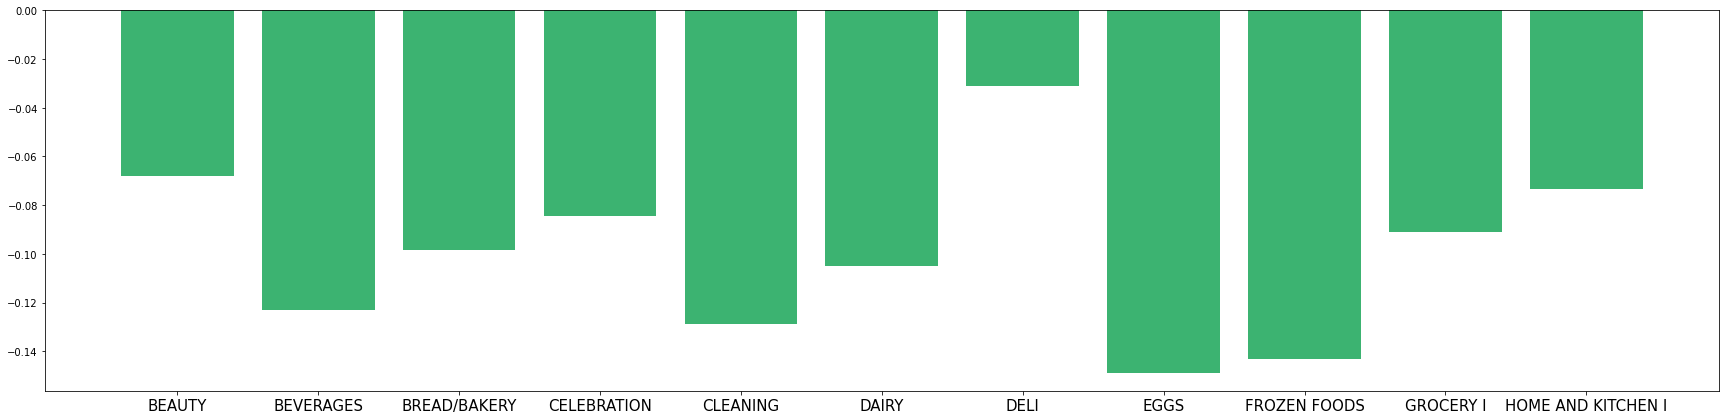

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = [30, 7])
plt.xticks(fontsize = 15)
plt.bar(check.iloc[range(11)].index, check.iloc[range(11)].values, color = 'mediumseagreen');

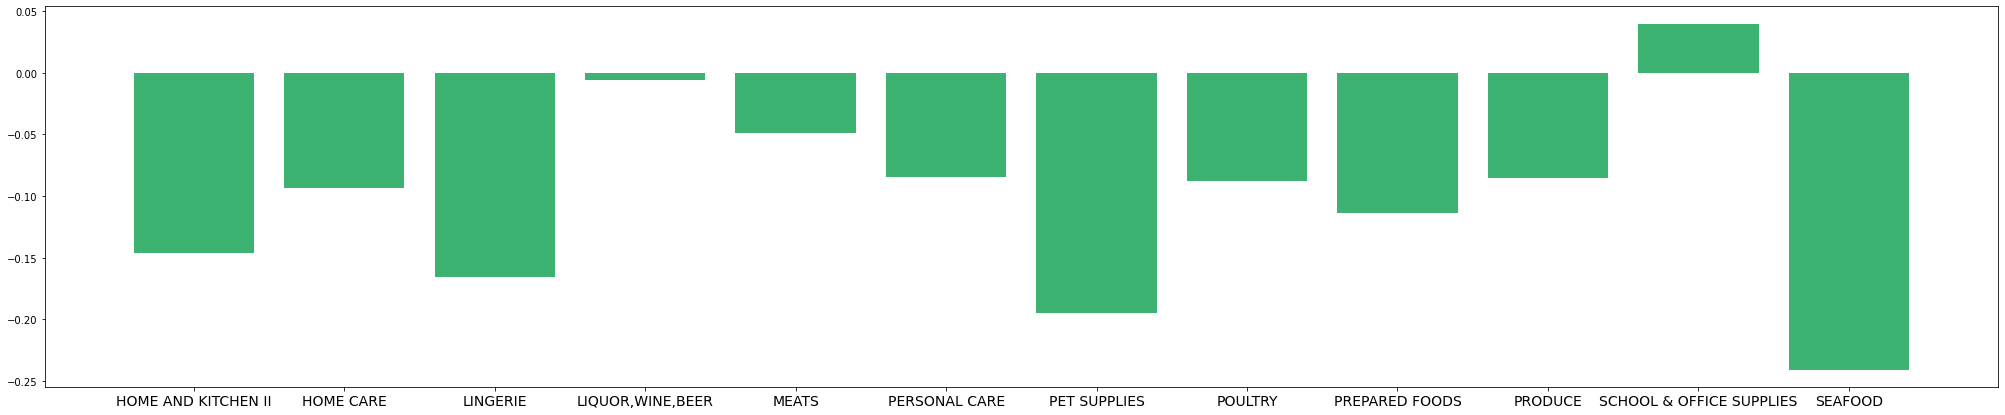

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = [35, 7])
plt.xticks(fontsize = 14)
plt.bar(check.iloc[range(11, 23)].index, check.iloc[range(11, 23)].values, color = 'mediumseagreen');

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c0b06fa9-9dc8-48e0-ad5a-d1d1aa37a190' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>